In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 15:45:28.438215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 15:45:28.438266: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/119


2022-05-07 15:45:32.100460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 15:45:32.100506: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 15:45:32.100531: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 15:45:32.100811: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


130/130 [==============================] - 3s 9ms/step - loss: 0.7014 - accuracy: 0.5073 - auc: 0.5202 - val_loss: 0.6927 - val_accuracy: 0.5208 - val_auc: 0.5395
Epoch 2/119
130/130 [==============================] - 1s 6ms/step - loss: 0.6973 - accuracy: 0.5119 - auc: 0.5222 - val_loss: 0.6900 - val_accuracy: 0.5365 - val_auc: 0.5548
Epoch 3/119
130/130 [==============================] - 1s 6ms/step - loss: 0.6939 - accuracy: 0.5200 - auc: 0.5327 - val_loss: 0.6882 - val_accuracy: 0.5525 - val_auc: 0.5711
Epoch 4/119
130/130 [==============================] - 1s 7ms/step - loss: 0.6933 - accuracy: 0.5184 - auc: 0.5318 - val_loss: 0.6865 - val_accuracy: 0.5631 - val_auc: 0.5889
Epoch 5/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6909 - accuracy: 0.5314 - auc: 0.5444 - val_loss: 0.6848 - val_accuracy: 0.5744 - val_auc: 0.6048
Epoch 6/119
130/130 [==============================] - 1s 6ms/step - loss: 0.6891 - accuracy: 0.5413 - auc: 0.5548 - val_loss: 0.6830 - v

Epoch 48/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5584 - accuracy: 0.7264 - auc: 0.7962 - val_loss: 0.5057 - val_accuracy: 0.7938 - val_auc: 0.8602
Epoch 49/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5598 - accuracy: 0.7212 - auc: 0.7936 - val_loss: 0.5031 - val_accuracy: 0.7957 - val_auc: 0.8614
Epoch 50/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5573 - accuracy: 0.7287 - auc: 0.7973 - val_loss: 0.5008 - val_accuracy: 0.7969 - val_auc: 0.8626
Epoch 51/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5575 - accuracy: 0.7276 - auc: 0.7969 - val_loss: 0.4986 - val_accuracy: 0.7992 - val_auc: 0.8637
Epoch 52/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5527 - accuracy: 0.7308 - auc: 0.8012 - val_loss: 0.4964 - val_accuracy: 0.7996 - val_auc: 0.8647
Epoch 53/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5531 - accuracy: 0.7350 - auc: 0.8015 - va

130/130 [==============================] - 1s 5ms/step - loss: 0.5085 - accuracy: 0.7756 - auc: 0.8429 - val_loss: 0.4531 - val_accuracy: 0.8322 - val_auc: 0.8836
Epoch 95/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5066 - accuracy: 0.7774 - auc: 0.8439 - val_loss: 0.4525 - val_accuracy: 0.8328 - val_auc: 0.8838
Epoch 96/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5050 - accuracy: 0.7772 - auc: 0.8444 - val_loss: 0.4518 - val_accuracy: 0.8330 - val_auc: 0.8841
Epoch 97/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5079 - accuracy: 0.7782 - auc: 0.8430 - val_loss: 0.4511 - val_accuracy: 0.8338 - val_auc: 0.8843
Epoch 98/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5056 - accuracy: 0.7787 - auc: 0.8440 - val_loss: 0.4506 - val_accuracy: 0.8342 - val_auc: 0.8846
Epoch 99/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5087 - accuracy: 0.7761 - auc: 0.8424 - val_loss: 0.450

130/130 [==============================] - 1s 5ms/step - loss: 0.6164 - accuracy: 0.6636 - auc: 0.7242 - val_loss: 0.5677 - val_accuracy: 0.7492 - val_auc: 0.8238
Epoch 21/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6090 - accuracy: 0.6724 - auc: 0.7348 - val_loss: 0.5613 - val_accuracy: 0.7548 - val_auc: 0.8286
Epoch 22/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6047 - accuracy: 0.6731 - auc: 0.7392 - val_loss: 0.5550 - val_accuracy: 0.7597 - val_auc: 0.8326
Epoch 23/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5993 - accuracy: 0.6809 - auc: 0.7474 - val_loss: 0.5490 - val_accuracy: 0.7653 - val_auc: 0.8366
Epoch 24/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.6833 - auc: 0.7495 - val_loss: 0.5431 - val_accuracy: 0.7704 - val_auc: 0.8409
Epoch 25/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5908 - accuracy: 0.6922 - auc: 0.7593 - val_loss: 0.537

130/130 [==============================] - 1s 5ms/step - loss: 0.5155 - accuracy: 0.7717 - auc: 0.8370 - val_loss: 0.4575 - val_accuracy: 0.8363 - val_auc: 0.8822
Epoch 67/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5178 - accuracy: 0.7743 - auc: 0.8360 - val_loss: 0.4567 - val_accuracy: 0.8358 - val_auc: 0.8826
Epoch 68/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5146 - accuracy: 0.7728 - auc: 0.8384 - val_loss: 0.4560 - val_accuracy: 0.8367 - val_auc: 0.8828
Epoch 69/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5141 - accuracy: 0.7725 - auc: 0.8383 - val_loss: 0.4552 - val_accuracy: 0.8375 - val_auc: 0.8831
Epoch 70/119
130/130 [==============================] - 1s 7ms/step - loss: 0.5116 - accuracy: 0.7715 - auc: 0.8392 - val_loss: 0.4542 - val_accuracy: 0.8375 - val_auc: 0.8834
Epoch 71/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5105 - accuracy: 0.7722 - auc: 0.8409 - val_loss: 0.453

130/130 [==============================] - 1s 5ms/step - loss: 0.4723 - accuracy: 0.8005 - auc: 0.8648 - val_loss: 0.4228 - val_accuracy: 0.8468 - val_auc: 0.8966
Epoch 113/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4714 - accuracy: 0.8003 - auc: 0.8662 - val_loss: 0.4221 - val_accuracy: 0.8473 - val_auc: 0.8969
Epoch 114/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4719 - accuracy: 0.7997 - auc: 0.8658 - val_loss: 0.4213 - val_accuracy: 0.8476 - val_auc: 0.8972
Epoch 115/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4695 - accuracy: 0.8025 - auc: 0.8678 - val_loss: 0.4206 - val_accuracy: 0.8476 - val_auc: 0.8975
Epoch 116/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4685 - accuracy: 0.8036 - auc: 0.8682 - val_loss: 0.4199 - val_accuracy: 0.8474 - val_auc: 0.8979
Epoch 117/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4692 - accuracy: 0.8026 - auc: 0.8673 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.5249 - accuracy: 0.7637 - auc: 0.8299 - val_loss: 0.4686 - val_accuracy: 0.8263 - val_auc: 0.8772
Epoch 39/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5216 - accuracy: 0.7635 - auc: 0.8316 - val_loss: 0.4672 - val_accuracy: 0.8264 - val_auc: 0.8776
Epoch 40/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5236 - accuracy: 0.7644 - auc: 0.8311 - val_loss: 0.4658 - val_accuracy: 0.8274 - val_auc: 0.8781
Epoch 41/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5230 - accuracy: 0.7657 - auc: 0.8325 - val_loss: 0.4646 - val_accuracy: 0.8277 - val_auc: 0.8786
Epoch 42/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5217 - accuracy: 0.7664 - auc: 0.8328 - val_loss: 0.4634 - val_accuracy: 0.8296 - val_auc: 0.8790
Epoch 43/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5194 - accuracy: 0.7669 - auc: 0.8338 - val_loss: 0.462

130/130 [==============================] - 1s 5ms/step - loss: 0.4764 - accuracy: 0.8022 - auc: 0.8636 - val_loss: 0.4256 - val_accuracy: 0.8436 - val_auc: 0.8948
Epoch 85/119
130/130 [==============================] - 1s 6ms/step - loss: 0.4757 - accuracy: 0.8007 - auc: 0.8638 - val_loss: 0.4248 - val_accuracy: 0.8436 - val_auc: 0.8952
Epoch 86/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4751 - accuracy: 0.8003 - auc: 0.8640 - val_loss: 0.4240 - val_accuracy: 0.8440 - val_auc: 0.8955
Epoch 87/119
130/130 [==============================] - 1s 6ms/step - loss: 0.4731 - accuracy: 0.8016 - auc: 0.8652 - val_loss: 0.4234 - val_accuracy: 0.8450 - val_auc: 0.8958
Epoch 88/119
130/130 [==============================] - 1s 6ms/step - loss: 0.4718 - accuracy: 0.8010 - auc: 0.8656 - val_loss: 0.4226 - val_accuracy: 0.8444 - val_auc: 0.8962
Epoch 89/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4701 - accuracy: 0.8036 - auc: 0.8670 - val_loss: 0.421

130/130 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.5231 - auc: 0.5357 - val_loss: 0.6870 - val_accuracy: 0.5479 - val_auc: 0.5738
Epoch 11/249
130/130 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5235 - auc: 0.5348 - val_loss: 0.6864 - val_accuracy: 0.5508 - val_auc: 0.5793
Epoch 12/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6926 - accuracy: 0.5248 - auc: 0.5359 - val_loss: 0.6859 - val_accuracy: 0.5546 - val_auc: 0.5840
Epoch 13/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6917 - accuracy: 0.5252 - auc: 0.5380 - val_loss: 0.6853 - val_accuracy: 0.5581 - val_auc: 0.5888
Epoch 14/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6907 - accuracy: 0.5313 - auc: 0.5450 - val_loss: 0.6847 - val_accuracy: 0.5609 - val_auc: 0.5941
Epoch 15/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6892 - accuracy: 0.5361 - auc: 0.5515 - val_loss: 0.684

130/130 [==============================] - 1s 4ms/step - loss: 0.6481 - accuracy: 0.6230 - auc: 0.6721 - val_loss: 0.6214 - val_accuracy: 0.7169 - val_auc: 0.7896
Epoch 57/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6445 - accuracy: 0.6286 - auc: 0.6823 - val_loss: 0.6180 - val_accuracy: 0.7218 - val_auc: 0.7944
Epoch 58/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6448 - accuracy: 0.6295 - auc: 0.6797 - val_loss: 0.6147 - val_accuracy: 0.7256 - val_auc: 0.7990
Epoch 59/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6422 - accuracy: 0.6310 - auc: 0.6834 - val_loss: 0.6112 - val_accuracy: 0.7311 - val_auc: 0.8037
Epoch 60/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6400 - accuracy: 0.6346 - auc: 0.6884 - val_loss: 0.6076 - val_accuracy: 0.7345 - val_auc: 0.8081
Epoch 61/249
130/130 [==============================] - 1s 6ms/step - loss: 0.6352 - accuracy: 0.6420 - auc: 0.6978 - val_loss: 0.603

130/130 [==============================] - 1s 4ms/step - loss: 0.5509 - accuracy: 0.7391 - auc: 0.8056 - val_loss: 0.4829 - val_accuracy: 0.8280 - val_auc: 0.8757
Epoch 103/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5494 - accuracy: 0.7408 - auc: 0.8063 - val_loss: 0.4819 - val_accuracy: 0.8286 - val_auc: 0.8760
Epoch 104/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5501 - accuracy: 0.7408 - auc: 0.8060 - val_loss: 0.4809 - val_accuracy: 0.8287 - val_auc: 0.8763
Epoch 105/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5446 - accuracy: 0.7423 - auc: 0.8102 - val_loss: 0.4796 - val_accuracy: 0.8296 - val_auc: 0.8766
Epoch 106/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5428 - accuracy: 0.7477 - auc: 0.8128 - val_loss: 0.4783 - val_accuracy: 0.8299 - val_auc: 0.8769
Epoch 107/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5480 - accuracy: 0.7407 - auc: 0.8082 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.5078 - accuracy: 0.7792 - auc: 0.8428 - val_loss: 0.4504 - val_accuracy: 0.8421 - val_auc: 0.8839
Epoch 149/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5067 - accuracy: 0.7802 - auc: 0.8435 - val_loss: 0.4498 - val_accuracy: 0.8419 - val_auc: 0.8840
Epoch 150/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5069 - accuracy: 0.7813 - auc: 0.8440 - val_loss: 0.4493 - val_accuracy: 0.8419 - val_auc: 0.8841
Epoch 151/249
130/130 [==============================] - 1s 5ms/step - loss: 0.5092 - accuracy: 0.7819 - auc: 0.8421 - val_loss: 0.4489 - val_accuracy: 0.8420 - val_auc: 0.8842
Epoch 152/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5069 - accuracy: 0.7803 - auc: 0.8431 - val_loss: 0.4484 - val_accuracy: 0.8428 - val_auc: 0.8843
Epoch 153/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5058 - accuracy: 0.7845 - auc: 0.8450 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.4859 - accuracy: 0.7971 - auc: 0.8565 - val_loss: 0.4317 - val_accuracy: 0.8469 - val_auc: 0.8901
Epoch 195/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4868 - accuracy: 0.7976 - auc: 0.8561 - val_loss: 0.4314 - val_accuracy: 0.8472 - val_auc: 0.8902
Epoch 196/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4864 - accuracy: 0.7968 - auc: 0.8569 - val_loss: 0.4311 - val_accuracy: 0.8468 - val_auc: 0.8904
Epoch 197/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4826 - accuracy: 0.7988 - auc: 0.8582 - val_loss: 0.4306 - val_accuracy: 0.8471 - val_auc: 0.8905
Epoch 198/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4831 - accuracy: 0.7986 - auc: 0.8581 - val_loss: 0.4302 - val_accuracy: 0.8474 - val_auc: 0.8906
Epoch 199/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4818 - accuracy: 0.7989 - auc: 0.8589 - val_loss: 

130/130 [==============================] - 1s 6ms/step - loss: 0.4642 - accuracy: 0.8089 - auc: 0.8690 - val_loss: 0.4149 - val_accuracy: 0.8507 - val_auc: 0.8975
Epoch 241/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4649 - accuracy: 0.8062 - auc: 0.8678 - val_loss: 0.4146 - val_accuracy: 0.8507 - val_auc: 0.8977
Epoch 242/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4643 - accuracy: 0.8075 - auc: 0.8690 - val_loss: 0.4143 - val_accuracy: 0.8512 - val_auc: 0.8979
Epoch 243/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4639 - accuracy: 0.8062 - auc: 0.8685 - val_loss: 0.4140 - val_accuracy: 0.8508 - val_auc: 0.8980
Epoch 244/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4615 - accuracy: 0.8092 - auc: 0.8705 - val_loss: 0.4135 - val_accuracy: 0.8505 - val_auc: 0.8982
Epoch 245/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4603 - accuracy: 0.8086 - auc: 0.8710 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.6573 - accuracy: 0.6017 - auc: 0.6500 - val_loss: 0.6356 - val_accuracy: 0.6765 - val_auc: 0.7558
Epoch 37/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6521 - accuracy: 0.6132 - auc: 0.6631 - val_loss: 0.6318 - val_accuracy: 0.6822 - val_auc: 0.7611
Epoch 38/249
130/130 [==============================] - 1s 6ms/step - loss: 0.6529 - accuracy: 0.6100 - auc: 0.6615 - val_loss: 0.6281 - val_accuracy: 0.6898 - val_auc: 0.7671
Epoch 39/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6492 - accuracy: 0.6174 - auc: 0.6687 - val_loss: 0.6242 - val_accuracy: 0.6963 - val_auc: 0.7725
Epoch 40/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6477 - accuracy: 0.6146 - auc: 0.6697 - val_loss: 0.6203 - val_accuracy: 0.7027 - val_auc: 0.7784
Epoch 41/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6446 - accuracy: 0.6248 - auc: 0.6784 - val_loss: 0.616

130/130 [==============================] - 1s 6ms/step - loss: 0.5418 - accuracy: 0.7488 - auc: 0.8138 - val_loss: 0.4719 - val_accuracy: 0.8285 - val_auc: 0.8785
Epoch 83/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5392 - accuracy: 0.7514 - auc: 0.8165 - val_loss: 0.4702 - val_accuracy: 0.8294 - val_auc: 0.8790
Epoch 84/249
130/130 [==============================] - 1s 6ms/step - loss: 0.5338 - accuracy: 0.7524 - auc: 0.8205 - val_loss: 0.4684 - val_accuracy: 0.8303 - val_auc: 0.8795
Epoch 85/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5382 - accuracy: 0.7532 - auc: 0.8184 - val_loss: 0.4673 - val_accuracy: 0.8310 - val_auc: 0.8799
Epoch 86/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5317 - accuracy: 0.7553 - auc: 0.8218 - val_loss: 0.4658 - val_accuracy: 0.8321 - val_auc: 0.8802
Epoch 87/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5329 - accuracy: 0.7553 - auc: 0.8224 - val_loss: 0.464

130/130 [==============================] - 1s 4ms/step - loss: 0.4954 - accuracy: 0.7920 - auc: 0.8510 - val_loss: 0.4341 - val_accuracy: 0.8464 - val_auc: 0.8896
Epoch 129/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4906 - accuracy: 0.7931 - auc: 0.8540 - val_loss: 0.4335 - val_accuracy: 0.8465 - val_auc: 0.8898
Epoch 130/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4918 - accuracy: 0.7942 - auc: 0.8531 - val_loss: 0.4330 - val_accuracy: 0.8471 - val_auc: 0.8900
Epoch 131/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4924 - accuracy: 0.7928 - auc: 0.8527 - val_loss: 0.4325 - val_accuracy: 0.8468 - val_auc: 0.8902
Epoch 132/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4896 - accuracy: 0.7925 - auc: 0.8540 - val_loss: 0.4320 - val_accuracy: 0.8470 - val_auc: 0.8904
Epoch 133/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4908 - accuracy: 0.7926 - auc: 0.8535 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.4659 - accuracy: 0.8040 - auc: 0.8681 - val_loss: 0.4135 - val_accuracy: 0.8504 - val_auc: 0.8993
Epoch 175/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4656 - accuracy: 0.8075 - auc: 0.8687 - val_loss: 0.4130 - val_accuracy: 0.8512 - val_auc: 0.8995
Epoch 176/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4656 - accuracy: 0.8059 - auc: 0.8681 - val_loss: 0.4127 - val_accuracy: 0.8508 - val_auc: 0.8997
Epoch 177/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4642 - accuracy: 0.8078 - auc: 0.8690 - val_loss: 0.4123 - val_accuracy: 0.8508 - val_auc: 0.8998
Epoch 178/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4602 - accuracy: 0.8093 - auc: 0.8715 - val_loss: 0.4117 - val_accuracy: 0.8509 - val_auc: 0.9000
Epoch 179/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4623 - accuracy: 0.8061 - auc: 0.8695 - val_loss: 

130/130 [==============================] - 0s 3ms/step - loss: 0.4491 - accuracy: 0.8106 - auc: 0.8767 - val_loss: 0.4009 - val_accuracy: 0.8532 - val_auc: 0.9063
Epoch 221/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4467 - accuracy: 0.8119 - auc: 0.8785 - val_loss: 0.4006 - val_accuracy: 0.8535 - val_auc: 0.9064
Epoch 222/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4461 - accuracy: 0.8130 - auc: 0.8789 - val_loss: 0.4004 - val_accuracy: 0.8531 - val_auc: 0.9064
Epoch 223/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4479 - accuracy: 0.8135 - auc: 0.8779 - val_loss: 0.4003 - val_accuracy: 0.8530 - val_auc: 0.9065
Epoch 224/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4461 - accuracy: 0.8108 - auc: 0.8786 - val_loss: 0.4001 - val_accuracy: 0.8532 - val_auc: 0.9066
Epoch 225/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4454 - accuracy: 0.8126 - auc: 0.8789 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.6792 - accuracy: 0.5662 - auc: 0.5944 - val_loss: 0.6652 - val_accuracy: 0.6486 - val_auc: 0.7113
Epoch 17/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6755 - accuracy: 0.5754 - auc: 0.6068 - val_loss: 0.6627 - val_accuracy: 0.6554 - val_auc: 0.7199
Epoch 18/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6763 - accuracy: 0.5718 - auc: 0.6024 - val_loss: 0.6602 - val_accuracy: 0.6631 - val_auc: 0.7284
Epoch 19/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6740 - accuracy: 0.5768 - auc: 0.6096 - val_loss: 0.6576 - val_accuracy: 0.6697 - val_auc: 0.7360
Epoch 20/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6701 - accuracy: 0.5882 - auc: 0.6244 - val_loss: 0.6546 - val_accuracy: 0.6741 - val_auc: 0.7439
Epoch 21/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6689 - accuracy: 0.5913 - auc: 0.6268 - val_loss: 0.651

130/130 [==============================] - 1s 6ms/step - loss: 0.5330 - accuracy: 0.7587 - auc: 0.8226 - val_loss: 0.4714 - val_accuracy: 0.8285 - val_auc: 0.8775
Epoch 63/249
130/130 [==============================] - 1s 6ms/step - loss: 0.5306 - accuracy: 0.7564 - auc: 0.8245 - val_loss: 0.4699 - val_accuracy: 0.8304 - val_auc: 0.8779
Epoch 64/249
130/130 [==============================] - 1s 6ms/step - loss: 0.5320 - accuracy: 0.7567 - auc: 0.8235 - val_loss: 0.4688 - val_accuracy: 0.8312 - val_auc: 0.8783
Epoch 65/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5288 - accuracy: 0.7603 - auc: 0.8267 - val_loss: 0.4674 - val_accuracy: 0.8321 - val_auc: 0.8786
Epoch 66/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5261 - accuracy: 0.7636 - auc: 0.8291 - val_loss: 0.4660 - val_accuracy: 0.8325 - val_auc: 0.8790
Epoch 67/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5253 - accuracy: 0.7650 - auc: 0.8298 - val_loss: 0.464

130/130 [==============================] - 1s 6ms/step - loss: 0.4834 - accuracy: 0.7991 - auc: 0.8588 - val_loss: 0.4306 - val_accuracy: 0.8464 - val_auc: 0.8911
Epoch 109/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4840 - accuracy: 0.7981 - auc: 0.8589 - val_loss: 0.4301 - val_accuracy: 0.8462 - val_auc: 0.8914
Epoch 110/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4826 - accuracy: 0.7994 - auc: 0.8604 - val_loss: 0.4294 - val_accuracy: 0.8468 - val_auc: 0.8916
Epoch 111/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4820 - accuracy: 0.8020 - auc: 0.8604 - val_loss: 0.4288 - val_accuracy: 0.8468 - val_auc: 0.8918
Epoch 112/249
130/130 [==============================] - 1s 7ms/step - loss: 0.4802 - accuracy: 0.8031 - auc: 0.8612 - val_loss: 0.4281 - val_accuracy: 0.8464 - val_auc: 0.8922
Epoch 113/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4809 - accuracy: 0.8028 - auc: 0.8617 - val_loss: 

130/130 [==============================] - 1s 6ms/step - loss: 0.4525 - accuracy: 0.8100 - auc: 0.8758 - val_loss: 0.4055 - val_accuracy: 0.8494 - val_auc: 0.9036
Epoch 155/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4548 - accuracy: 0.8110 - auc: 0.8746 - val_loss: 0.4051 - val_accuracy: 0.8497 - val_auc: 0.9039
Epoch 156/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4539 - accuracy: 0.8117 - auc: 0.8755 - val_loss: 0.4049 - val_accuracy: 0.8492 - val_auc: 0.9040
Epoch 157/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4525 - accuracy: 0.8119 - auc: 0.8759 - val_loss: 0.4045 - val_accuracy: 0.8498 - val_auc: 0.9042
Epoch 158/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4515 - accuracy: 0.8113 - auc: 0.8770 - val_loss: 0.4041 - val_accuracy: 0.8504 - val_auc: 0.9044
Epoch 159/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4514 - accuracy: 0.8112 - auc: 0.8768 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.4340 - accuracy: 0.8189 - auc: 0.8859 - val_loss: 0.3928 - val_accuracy: 0.8518 - val_auc: 0.9098
Epoch 201/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4354 - accuracy: 0.8178 - auc: 0.8856 - val_loss: 0.3926 - val_accuracy: 0.8521 - val_auc: 0.9098
Epoch 202/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4352 - accuracy: 0.8155 - auc: 0.8850 - val_loss: 0.3925 - val_accuracy: 0.8516 - val_auc: 0.9099
Epoch 203/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4328 - accuracy: 0.8197 - auc: 0.8867 - val_loss: 0.3923 - val_accuracy: 0.8516 - val_auc: 0.9100
Epoch 204/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4291 - accuracy: 0.8195 - auc: 0.8886 - val_loss: 0.3919 - val_accuracy: 0.8522 - val_auc: 0.9101
Epoch 205/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4351 - accuracy: 0.8181 - auc: 0.8854 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.4218 - accuracy: 0.8244 - auc: 0.8921 - val_loss: 0.3850 - val_accuracy: 0.8541 - val_auc: 0.9127
Epoch 247/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4193 - accuracy: 0.8264 - auc: 0.8933 - val_loss: 0.3848 - val_accuracy: 0.8538 - val_auc: 0.9127
Epoch 248/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4212 - accuracy: 0.8246 - auc: 0.8922 - val_loss: 0.3847 - val_accuracy: 0.8544 - val_auc: 0.9129
Epoch 249/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4221 - accuracy: 0.8241 - auc: 0.8918 - val_loss: 0.3846 - val_accuracy: 0.8543 - val_auc: 0.9129
{'learning_rate': 0.006, 'batch': 256, 'epoch': 177, 'optimizer': 'sgd', 'best_loss': {'loss': 0.38463294506073, 'epoch': 249}, 'best_auc': {'auc': 0.9128834009170532, 'epoch': 249}, 'best_accuracy': {'accuracy': 0.8543999791145325, 'epoch': 248}}
Epoch 1/6
4160/4160 [==============================] - 13s

4160/4160 [==============================] - 15s 4ms/step - loss: 0.5373 - accuracy: 0.8115 - auc: 0.8750 - val_loss: 0.5454 - val_accuracy: 0.8356 - val_auc: 0.8949
Epoch 6/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.5539 - accuracy: 0.8143 - auc: 0.8771 - val_loss: 0.4631 - val_accuracy: 0.8380 - val_auc: 0.8965
{'learning_rate': 0.006, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.42294803261756897, 'epoch': 1}, 'best_auc': {'auc': 0.9011813402175903, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.8415499925613403, 'epoch': 3}}
Epoch 1/6
4160/4160 [==============================] - 19s 4ms/step - loss: 0.4791 - accuracy: 0.7875 - auc: 0.8598 - val_loss: 0.3845 - val_accuracy: 0.8420 - val_auc: 0.9088
Epoch 2/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.4094 - accuracy: 0.8323 - auc: 0.8962 - val_loss: 0.3818 - val_accuracy: 0.8478 - val_auc: 0.9127
Epoch 3/6
4160/4160 [==============================] - 16s 4m

4160/4160 [==============================] - 16s 4ms/step - loss: 0.4801 - accuracy: 0.8014 - auc: 0.8633 - val_loss: 0.4245 - val_accuracy: 0.8475 - val_auc: 0.8938
{'learning_rate': 0.1, 'batch': 8, 'epoch': 6, 'optimizer': 'adadelta', 'best_loss': {'loss': 0.42445048689842224, 'epoch': 10}, 'best_auc': {'auc': 0.8938435316085815, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.8475000262260437, 'epoch': 10}}
Epoch 1/10
4160/4160 [==============================] - 18s 4ms/step - loss: 0.6641 - accuracy: 0.5909 - auc: 0.6337 - val_loss: 0.5824 - val_accuracy: 0.7555 - val_auc: 0.8213
Epoch 2/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.5859 - accuracy: 0.6979 - auc: 0.7642 - val_loss: 0.4899 - val_accuracy: 0.8156 - val_auc: 0.8701
Epoch 3/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.5440 - accuracy: 0.7428 - auc: 0.8117 - val_loss: 0.4655 - val_accuracy: 0.8330 - val_auc: 0.8785
Epoch 4/10
4160/4160 [==============================] - 

4160/4160 [==============================] - 16s 4ms/step - loss: 0.4195 - accuracy: 0.8325 - auc: 0.8944 - val_loss: 0.3771 - val_accuracy: 0.8478 - val_auc: 0.9108
Epoch 12/18
4160/4160 [==============================] - 15s 4ms/step - loss: 0.4148 - accuracy: 0.8364 - auc: 0.8962 - val_loss: 0.3776 - val_accuracy: 0.8503 - val_auc: 0.9158
Epoch 13/18
4160/4160 [==============================] - 14s 3ms/step - loss: 0.4151 - accuracy: 0.8334 - auc: 0.8971 - val_loss: 0.3908 - val_accuracy: 0.8536 - val_auc: 0.9126
Epoch 14/18
4160/4160 [==============================] - 14s 3ms/step - loss: 0.4128 - accuracy: 0.8347 - auc: 0.8975 - val_loss: 0.3964 - val_accuracy: 0.8350 - val_auc: 0.9098
Epoch 15/18
4160/4160 [==============================] - 15s 4ms/step - loss: 0.4192 - accuracy: 0.8293 - auc: 0.8953 - val_loss: 0.3859 - val_accuracy: 0.8486 - val_auc: 0.9149
Epoch 16/18
4160/4160 [==============================] - 16s 4ms/step - loss: 0.4147 - accuracy: 0.8342 - auc: 0.8978 - va

4160/4160 [==============================] - 15s 4ms/step - loss: 0.4790 - accuracy: 0.7990 - auc: 0.8586 - val_loss: 0.4361 - val_accuracy: 0.8202 - val_auc: 0.8826
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 12, 'optimizer': 'nadam', 'best_loss': {'loss': 0.4172714352607727, 'epoch': 15}, 'best_auc': {'auc': 0.9009038209915161, 'epoch': 14}, 'best_accuracy': {'accuracy': 0.8363999724388123, 'epoch': 14}}


In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.5015 - accuracy: 0.7719 - auc: 0.8445 - val_loss: 0.3894 - val_accuracy: 0.8451 - val_auc: 0.9073
Epoch 2/6
4160/4160 [==============================] - 23s 5ms/step - loss: 0.4017 - accuracy: 0.8359 - auc: 0.9009 - val_loss: 0.3673 - val_accuracy: 0.8541 - val_auc: 0.9187
Epoch 3/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.3835 - accuracy: 0.8424 - auc: 0.9086 - val_loss: 0.3573 - val_accuracy: 0.8546 - val_auc: 0.9209
Epoch 4/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.3755 - accuracy: 0.8488 - auc: 0.9120 - val_loss: 0.3604 - val_accuracy: 0.8543 - val_auc: 0.9190
Epoch 5/6
4160/4160 [==============================] - 23s 6ms/step - loss: 0.3703 - accuracy: 0.8488 - auc: 0.9148 - val_loss: 0.3622 - val_accuracy: 0.8551 - val_auc: 0.9212
Epoch 6/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.3686 - accuracy: 0.8518 - auc: 0.9152 - va

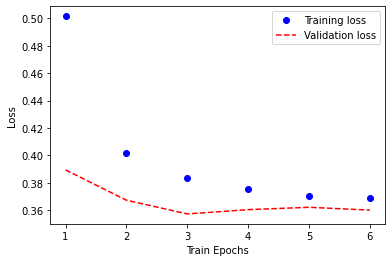

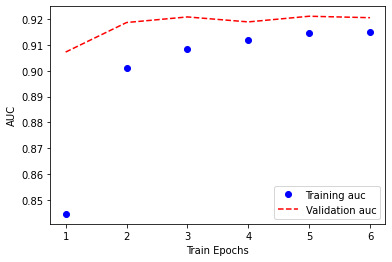

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

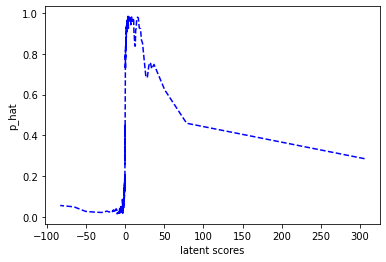

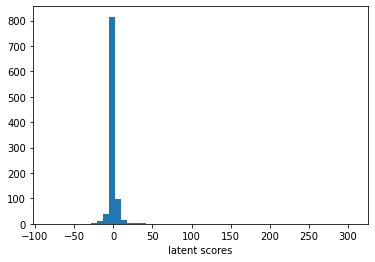

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

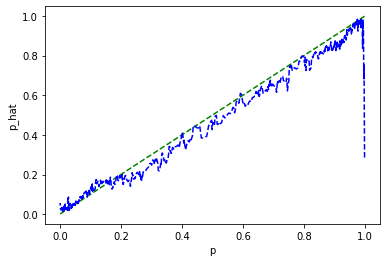

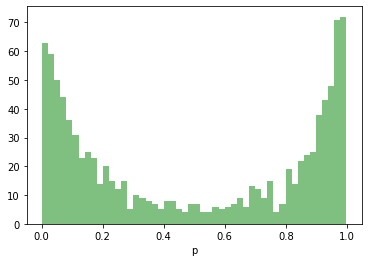

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

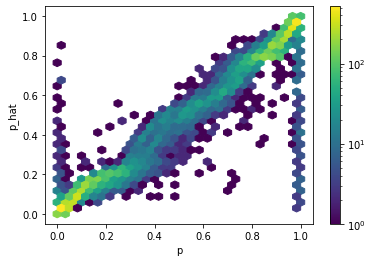

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

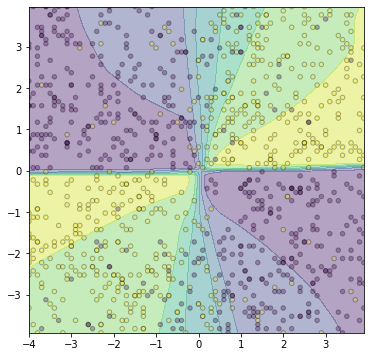

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.35471731424331665, 'epoch': 6},
 'best_auc': {'auc': 0.9221413135528564, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.8564000129699707, 'epoch': 6},
 'model': <keras.engine.sequential.Sequential at 0x7f01dc417220>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.43710723519325256, 'epoch': 119},
  'best_auc': {'auc': 0.8902122378349304, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.838949978351593, 'epoch': 119}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.41786259412765503, 'epoch': 119},
  'best_auc': {'auc': 0.8987679481506348, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.8478999733924866, 'epoch': 119}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.40173760056495667, 'epoch': 119},
  'best_auc': {'auc': 0.9057403206825256, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.8501999974250793, 'epoch': 116}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.41195952892303467, 'epoch': 249},
  'best_auc': {'auc': 0.8990054726600647, 'epoch': 249},
  

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25